# Project 3 - Face Morphing
Romil Bhardwaj

Before running this notebook, please annotate your faces using annotate.py

In [2]:
import copy
import csv
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.spatial.qhull import Delaunay
from skimage.color import rgb2gray
from skimage.draw import draw
from skimage.transform import rescale, resize
import os
import time

## Define functions

In [59]:
def get_affine_transform(tri1_pts, tri2_pts):
    m1 = np.array([tri1_pts[:,0], tri1_pts[:, 1], np.ones(3)])
    m2 = np.array([tri2_pts[:,0], tri2_pts[:, 1], np.ones(3)])
    return np.matmul(m2, np.linalg.inv(m1))

def masked_affine_tranform(im, mask, affine_transform):
    affine_0, affine_1, _ = np.matmul(np.linalg.inv(affine_transform), mask).astype(np.int)
    mask_0, mask_1, _ = mask.astype(np.int)
    result = np.zeros_like(im)
    result[mask_1, mask_0] = im[affine_1, affine_0]
    return result

def read_keypoints(csv_path):
    with open(csv_path, 'r') as f:
        return np.array([list(map(float,rec)) for rec in csv.reader(f, delimiter=',')])

def read_img_and_keypoints(img_path):
    img = skio.imread(img_path)
    
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    csv_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.csv')
    
    keypoints = read_keypoints(csv_path)
    return img, keypoints

def get_triangle_mask(triangle, image_shape):
    points = draw.polygon(triangle[:,0], triangle[:,1], shape=(image_shape[1], image_shape[0], image_shape[2]))
    return np.vstack([points, np.ones(len(points[0]))])

def morph(im1, im2, pts1, pts2, triangles, warp_frac, dissolve_frac):
    avg_points = (dissolve_frac * pts1 + (1 - dissolve_frac) * pts2)
    result_img = np.zeros_like(im1, dtype=np.float)
    for t in triangles:
        mask = get_triangle_mask(avg_points[t], im1.shape)
        affine_tranform1 = get_affine_transform(pts1[t], avg_points[t])
        affine_tranform2 = get_affine_transform(pts2[t], avg_points[t])
        result_img += (warp_frac * masked_affine_tranform(im1, mask, affine_tranform1) + (1-warp_frac) * masked_affine_tranform(im2, mask, affine_tranform2)) / 255
    return result_img

def create_morph_vid(im1, im2, pts1, pts2, num_keyframes, out_path, loop_count=3):
    triangles = Delaunay(pts1).simplices
    warp_fracs = np.linspace(0,1,num_keyframes)
    dissolve_fracs = np.linspace(0,1,num_keyframes)
    frames = []
    fig = plt.figure()
    for warp_frac, dissolve_frac in zip(warp_fracs, dissolve_fracs):
        morphed_im = morph(im1, im2, pts1, pts2, triangles, warp_frac, dissolve_frac)
        mplframe = plt.imshow(morphed_im)
        plt.tight_layout()
        frames.append([mplframe])
    
    # Create reversed frames and loop loop_count times
    write_frames = (frames + list(reversed(frames)))*loop_count
    
    #fig.set_size_inches(int(im1.shape[1]/50), int(im1.shape[0]/50), 10)
    vid = animation.ArtistAnimation(fig, write_frames, interval=100000, repeat=False)
    vid.save(out_path, writer=animation.writers['ffmpeg'](fps=5))
    
    # Save midway face
    out_filename = os.path.splitext(os.path.basename(out_path))[0]
    midwayim_path = os.path.join(os.path.dirname(out_path), f'{out_filename}_midway.jpg')
    midway_img = morph(im1, im2, pts1, pts2, triangles, warp_frac=0.5, dissolve_frac=0.5)
    skio.imsave(midwayim_path, midway_img)
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


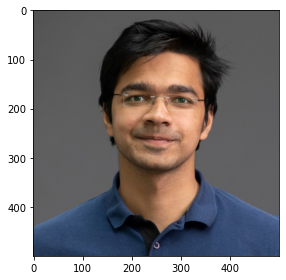

In [60]:
im1_path = 'imgs/jamesmay.jpg'
im2_path = 'imgs/romil.jpg'
im1, pts1 = read_img_and_keypoints(im1_path)
im2, pts2 = read_img_and_keypoints(im2_path)
create_morph_vid(im1, im2, pts1, pts2, 10, 'out.mp4')